# Load MR images in Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/M2_MLSP'

/content/drive/MyDrive/M2_MLSP


# Mixed precision policy

In order to make our models faster, we will use [TensorFlow mixed-precision](https://www.tensorflow.org/guide/mixed_precision).

In [3]:
from preprocessing import preprocess

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
import tensorflow as tf
from tensorflow.data import Dataset
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Data pipeline

We will use a data pipeline very similar to the one defined in practical 3. We simply need to modify our Python generator in order to adapt it to residual learning. For that, it must yield the 3T MR image and the residual (7T-3T image) instead of the 3T and 7T image.

## Python generator

In [4]:
def my_generator(ids):
  for id_ in ids:

    img_3T = np.load(f'img_3T_{id_}.npy')
    img_7T = np.load(f'img_7T_{id_}.npy')

    yield (img_3T, img_7T-img_3T)

## Patch extraction

In [5]:
def get_patches(img_3T, img_7T):
  xsize, ysize, zsize = img_3T.shape
  x, y, z = np.random.randint([xsize-64-60, ysize-64-60, zsize-3-60])
  return img_3T[x+30:x+30+64, y+30:y+30+64, z+30:z+30+3], img_7T[x+30:x+30+64, y+30:y+30+64, z+30:z+30+3]

## Tensorflow dataset

In [6]:
def instantiate_dataset(ids=range(10), deterministic=True):
  hop = lambda: my_generator(ids)  # don't worry about it
  dataset = Dataset.from_generator(hop, output_signature=(tf.TensorSpec(shape=(182, 218, 182), dtype=tf.float32),
                                                          tf.TensorSpec(shape=(182, 218, 182), dtype=tf.float32)))
  dataset = dataset.cache()

  dataset = dataset.shuffle(1, reshuffle_each_iteration=True)
  dataset = dataset.repeat(40)
  dataset = dataset.map(get_patches, num_parallel_calls = 8)

  dataset = dataset.batch(32)

  dataset = dataset.prefetch(10)
  return dataset


# Model architecture

We will here implement the main ideas described in the [reference paper](https://www-sciencedirect-com.ressources-electroniques.univ-lille.fr/science/article/pii/S1361841520300293), i.e. the residual learning, WAT layers and DBlocks. As these 3 elements imply complex architectures (multiple inputs, concatenations, skip connections...), we will use the [functional API](https://www.tensorflow.org/guide/keras/functional).

Notes:
  - the filter weights in the convolutional layers are initialized with the *HeNormal* initializer.
  - most of the convolutional layers are followed by a relu activation

## WAT layer

Define a function that implements a WAT layer as described in the paper. This function returns a keras model that will itself be used in the main model (you can define it as a keras layer if you prefer).

The returned *keras.Model* instance will take 2 inputs:
  - feature maps from previous layer $\rightarrow$ shape `(None,None,64)`
  - wavelet detail coefficients $\rightarrow$ shape `(None,None,9)` (3 coefficients * 3 axial slices)

As described in the section 3.2 of the article, this block applies 2 * 2 convolutions on the wavelet coefficients in order to compute the affine parameters $\gamma$ et $\beta$ that will be used to perform element-wise multiplication and addition on the feature maps from the previous layer.

In [7]:
from tensorflow.keras import Input, layers

In [8]:
def WAT():
  features = Input(shape=(None, None, 64))
  details = Input(shape=(None, None, 9))
  gamma = layers.Conv2D(filters=64, kernel_size=(2, 2), padding='same', activation='relu')(details)
  beta = layers.Conv2D(filters=64, kernel_size=(2, 2), padding='same', activation='relu')(details)
  print(features, gamma)
  output = layers.multiply([features, gamma])
  output = layers.add([output, beta])
  return tf.keras.Model(inputs=[features, details], outputs=output)

Plot a WAT layer with `keras.plot_model`.

In [9]:
from tensorflow.keras.utils import plot_model

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float16, name=None), name='conv2d/Relu:0', description="created by layer 'conv2d'")


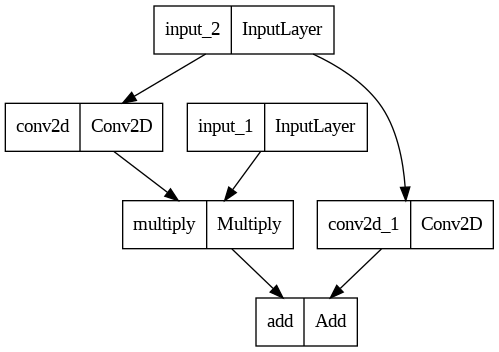

In [10]:
plot_model(WAT())

## DBlock

Similarly, define a function that implements a DBlock as described in the paper (Figure 4). The returned *keras.Model* instance will take the feature maps from the previous layer as input (shape `(None,None,64)`).

DBlocks are composed of 2 parts: the enhancement unit and the depression unit. The enhancement unit comprises 6 convolutions that are compiled in a short path and a long path. Slicing operations split intermediate feature maps into 16 and 48 channels for the short and the long path, respectively ([Lambda layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda) and [Tensor slicing](https://www.tensorflow.org/guide/tensor_slicing) can be useful). A concatenation operation is also used to combine input and intermediate feature maps.

There are 3 different types of depression unit:
  - *downsampling* $\rightarrow$ A convolution with stride $2^2$ that downsamples the feature maps
  - *upsamling* $\rightarrow$ A convolution with stride $1^2$ followed by a transposed convolution with stride $2^2$ that upsamples the feature maps
  - *simple* $\rightarrow$ A convolution with stride $1^2$.

Your function can take an argument that sets the type of depression unit in the returned DBlock.

In [11]:
def DBlock(depression_type='downsampling'):
  inputs = Input(shape=(None, None, 64))

  before = layers.Conv2D(filters=48, kernel_size=(3, 3), strides=(1, 1), 
                         padding='same', activation='relu')(inputs)
  before = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                         padding='same', activation='relu')(before)
  before = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), 
                         padding='same', activation='relu')(before)
  
  short, long = layers.Lambda(lambda x: tf.split(x, [16, 48], axis=-1))(before)

  short = layers.Concatenate(axis=-1)([short, inputs])

  long = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), 
                       padding='same', activation='relu')(long)
  long = layers.Conv2D(filters=48, kernel_size=(3, 3), strides=(1, 1), 
                       padding='same', activation='relu')(long)
  long = layers.Conv2D(filters=80, kernel_size=(3, 3), strides=(1, 1), 
                       padding='same', activation='relu')(long)

  merged = layers.add([short, long])

  if depression_type == 'downsampling':
      depression = layers.Conv2D(filters=64, kernel_size=(1, 1), strides=(2, 2), padding='valid')(merged)
  elif depression_type == 'upsampling':
      depression = layers.Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='valid')(merged)
      depression = layers.Conv2DTranspose(filters=64, kernel_size=(1, 1), strides=(2, 2), padding='valid')(depression)
  elif depression_type == 'simple':
      depression = layers.Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='valid')(merged)

  return tf.keras.Model(inputs=inputs, outputs=depression)

Plot a DBlock with `keras.plot_model`.

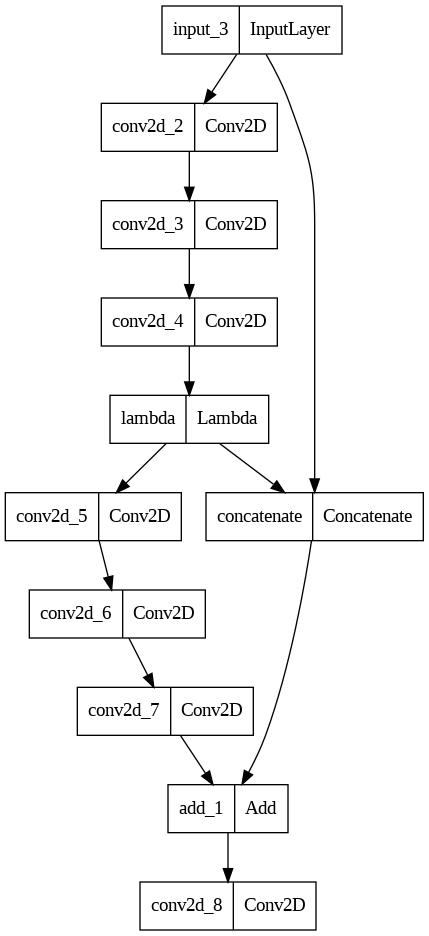

In [12]:
plot_model(DBlock())

## Global architecture

Define a function that implements a model as described in the article. The model combines WAT layers and DBlocks.

To compute the wavelet coefficients, you can use the **tensorflow-wavelets** package. More precisely, you can use layers `DWT(wavelet_name="haar", concat=0, dtype='float32')` to compute 4 wavelet coefficients from each input channel. 3 of them will be given to a WAT layer (the 3 precision coefficients) and the other will be used to compute recursively the next wavelet coefficients (again you can use tensor slicing).

The model is splitted in an extraction branch and a reconstruction branch. The extraction branch comprises 2 convolutions, 3 *downsampling* DBlocks (each one followed by a WAT layer) and a *simple* DBlock. The reconstruction branch comprises a *simple* DBlock, 3 *upsampling* DBlocks and 2 convolutions. The last convolution is followed by a *tanh* activation (`Activation('tanh', dtype='float32')`) as we want to estimate residuals.

In [16]:
# !pip install tensorflow_wavelets

In [17]:
from tensorflow_wavelets.Layers.DWT import DWT

In [18]:
inputs = Input(shape=(64, 64, 3))
wavelets = DWT(wavelet_name='haar', concat=0, dtype='float32')(inputs)
wavelets

<KerasTensor: shape=(None, 32, 32, 12) dtype=float32 (created by layer 'dwt')>

In [19]:
def WATNet():
  inputs = Input(shape=(64, 64, 3))

  # Feature Extraction Branch
  wavelets = DWT(wavelet_name='haar', concat=0, dtype='float32')(inputs)
  approx, details = layers.Lambda(lambda x: tf.split(x, [3, 9], axis=-1))(wavelets)

  conv = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), 
                         padding='same', activation='relu')(inputs)
  conv = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), 
                         padding='same', activation='relu')(conv)


  features = DBlock('downsampling')(conv)
  wat = WAT()([features, details])

  ###

  wavelets = DWT(wavelet_name='haar', concat=0, dtype='float32')(approx)
  approx, details = layers.Lambda(lambda x: tf.split(x, [3, 9], axis=-1))(wavelets)

  features = DBlock('downsampling')(wat)
  wat = WAT()([features, details])
  
  ###
  
  wavelets = DWT(wavelet_name='haar', concat=0, dtype='float32')(approx)
  approx, details = layers.Lambda(lambda x: tf.split(x, [3, 9], axis=-1))(wavelets)

  features = DBlock('downsampling')(wat)
  wat = WAT()([features, details])

  ###

  features = DBlock('simple')(wat)

  ###### Image Reconstruction Branch

  features = DBlock('simple')(features)
  features = DBlock('upsampling')(features)
  features = DBlock('upsampling')(features)
  features = DBlock('upsampling')(features)
  
  conv = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), 
                         padding='same', activation='relu')(features)
  conv = layers.Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), 
                         padding='same')(conv)
  conv = layers.Activation('tanh', dtype='float32')(conv)

  final = layers.Add()([inputs, conv])


  return tf.keras.Model(inputs=inputs, outputs=final)

Plot your model architecture with `keras.plot_model`.

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name='input_7'), name='input_7', description="created by layer 'input_7'") KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float16, name=None), name='conv2d_18/Relu:0', description="created by layer 'conv2d_18'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name='input_10'), name='input_10', description="created by layer 'input_10'") KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float16, name=None), name='conv2d_27/Relu:0', description="created by layer 'conv2d_27'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name='input_13'), name='input_13', description="created by layer 'input_13'") KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float16, name=None), name='conv2d_36/Relu:0', description="created by layer 'conv2d_36'")


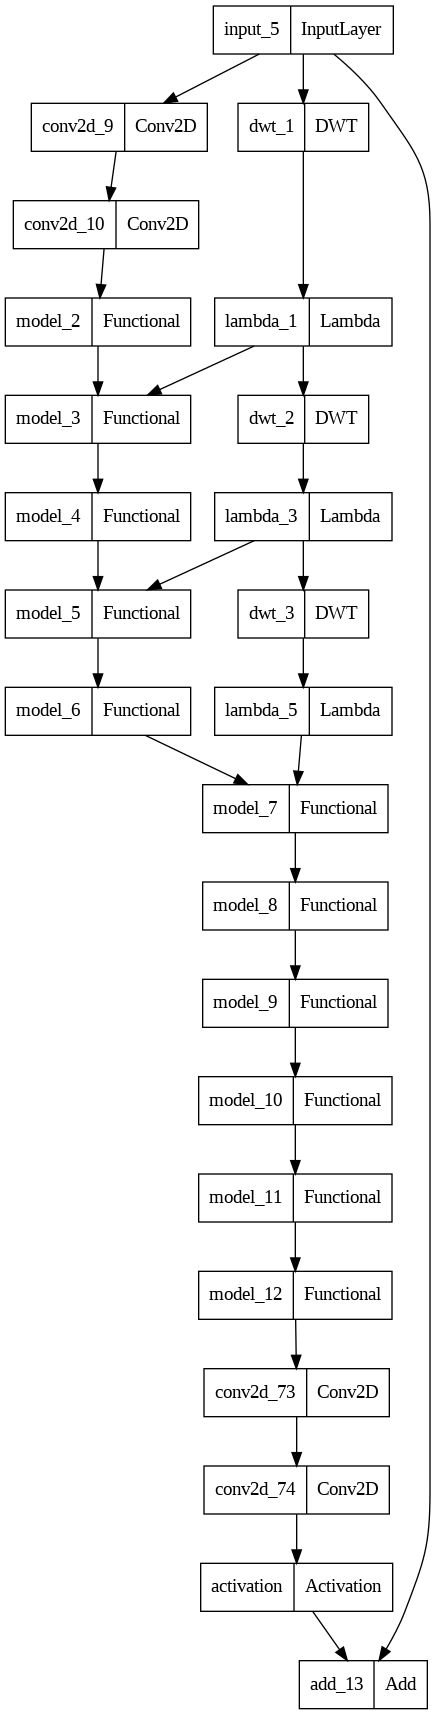

In [20]:
plot_model(WATNet())

# Inference function

We will adapt the inference function we defined in practical 3. Firstly, the models now infer residuals (not directly images as before); we therefore need to add the inferred maps to the input 3T MRI in order to obtain the 7T image. Secondly, the introduction of downsampling and upsampling operations requires to have feature maps with width and height divisible by 2. Thus, the input patches must have width and height divisible by $2^3$ (3 *downsampling*/*upsampling* DBlocks), which is the case for `(64,64,3)` but not for `(182,218,3)`. A way to circumvent this issue is to zero-pad the patches before the inference.

In [21]:
def inference_function(mrimage, model):
  # turns out this is a complicated way of doing it but whatever it works
  startx, endx = 30, 182-30
  starty, endy = 30, 218-30
  startz, endz = 30, 182-30

  inferred_image = mrimage.copy()

  # Remove non-excluded slices:
  inferred_image[startx:endx, starty:endy, startz:endz] = 0
  for z in range(startz, endz-2): # iterate through volume and add each inferred patch
    for x in [30, 88]:
      for y in [30, 94, 124]:
        inferred_patch = model(mrimage[x:x+64, y:y+64, z:z+3].reshape(-1, 64, 64, 3))[0]
        inferred_image[x:x+64, y:y+64, z:z+3] += inferred_patch

  # Overlap on x
  inferred_image[88:94, starty:endy, startz:endz] /= 2
  # Overlap on y
  inferred_image[startx:endx, 124:158, startz:endz] /= 2
  # Overlap on z
  inferred_image[startx:endx, starty:endy, startz+2:endz-2] /= 3
  inferred_image[startx:endx, starty:endy, startz+1] /= 2
  inferred_image[startx:endx, starty:endy, endz-2] /= 2

  return inferred_image

# Training and evaluation

For this section, you should be able to reuse the same code as practical 3.

## Display function

In [22]:
def display_slices(mrimage, x=92, y=109, z=92):
  fig, axes = plt.subplots(2, 2, figsize=(12,12))
  ((ax1, ax2), (ax3, _)) = axes
  ax1.imshow(mrimage[x,:,:])
  ax1.set_title(f'Slice for x={x}')
  ax2.imshow(mrimage[:,y,:])
  ax2.set_title(f'Slice for y={y}')
  ax3.imshow(mrimage[:,:,z])
  ax3.set_title(f'Slice for z={z}')

  # Remove x and y axis:
  for ax in axes.flatten():
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    for spine in ['top', 'right', 'left', 'bottom']:
      ax.spines[spine].set_visible(False)
  fig.show()

## Training configuration

In [23]:
# to re-run before running the next cell
n_epochs = 20
loss ='mae'

def my_generator(ids):
  for id_ in ids:

    img_3T = np.load(f'img_3T_{id_}.npy')
    img_7T = np.load(f'img_7T_{id_}.npy')

    yield (img_3T, img_7T)

In [25]:
import glob
paths = glob.glob('*.gz')
imgs_3T, imgs_7T = preprocess(paths)

## Execution

Fold 0
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name='input_37'), name='input_37', description="created by layer 'input_37'") KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float16, name=None), name='conv2d_150/Relu:0', description="created by layer 'conv2d_150'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name='input_40'), name='input_40', description="created by layer 'input_40'") KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float16, name=None), name='conv2d_159/Relu:0', description="created by layer 'conv2d_159'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name='input_43'), name='input_43', description="created by layer 'input_43'") KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float16, name=None), name='conv2d_168/Relu:0', description="created by layer 'conv2d_168'")
0.16378801045416821 --> 

<ipython-input-26-ca6ceec9576f>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-22-c0b35bf31ffa>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(2, 2, figsize=(12,12))


0.16378801045416783 --> 0.18793418475896462
Fold 6
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name='input_127'), name='input_127', description="created by layer 'input_127'") KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float16, name=None), name='conv2d_546/Relu:0', description="created by layer 'conv2d_546'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name='input_130'), name='input_130', description="created by layer 'input_130'") KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float16, name=None), name='conv2d_555/Relu:0', description="created by layer 'conv2d_555'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name='input_133'), name='input_133', description="created by layer 'input_133'") KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float16, name=None), name='conv2d_564/Relu:0', description="cre

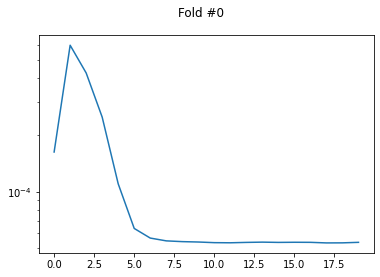

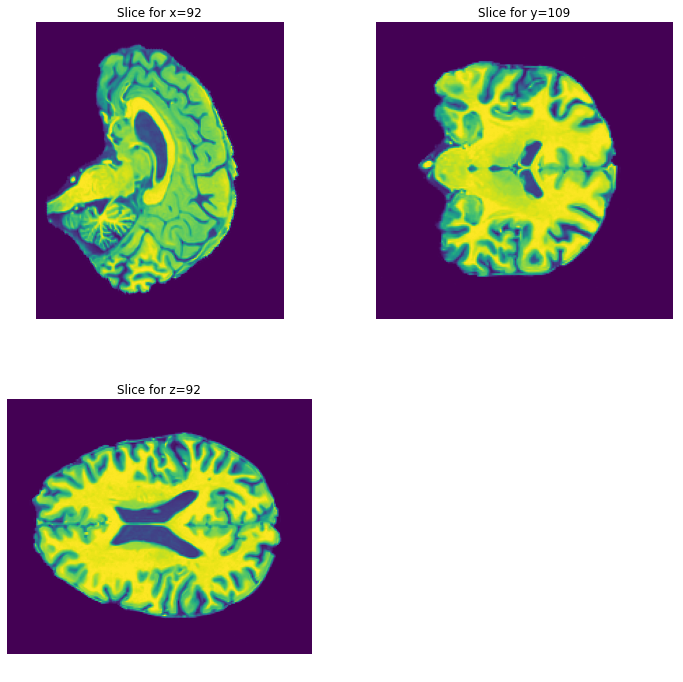

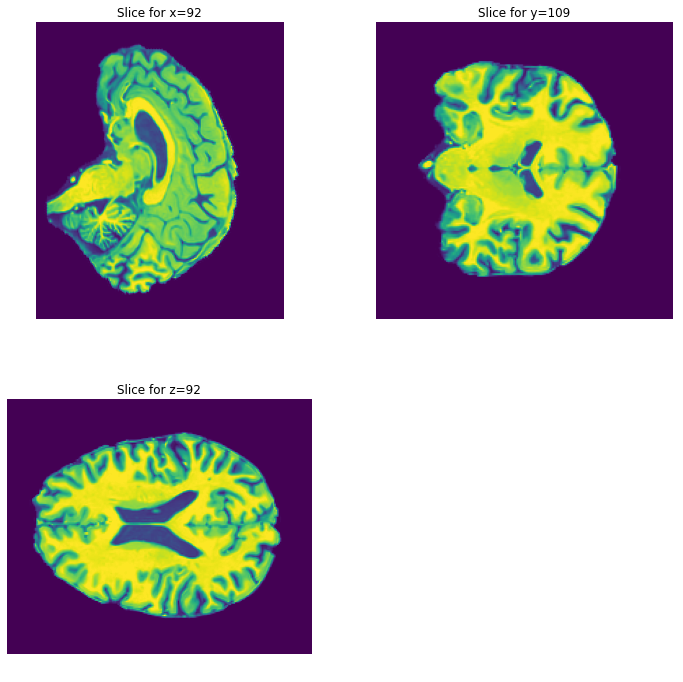

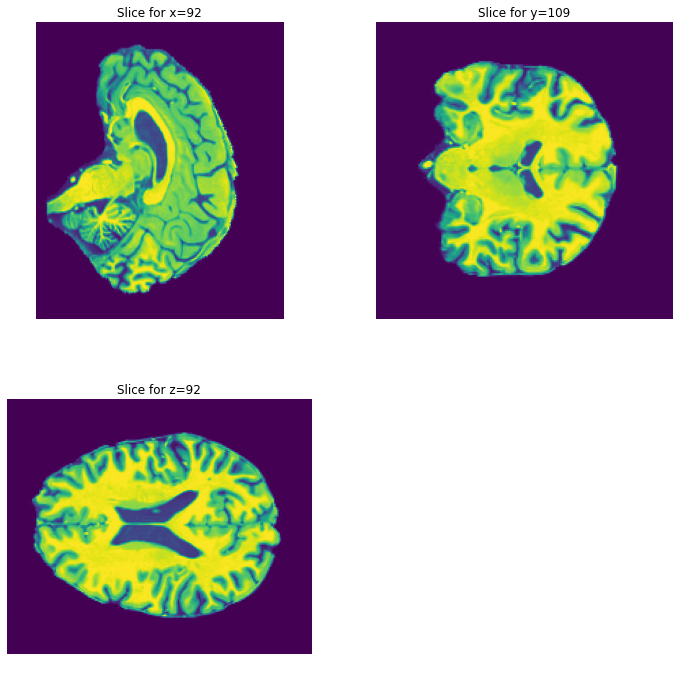

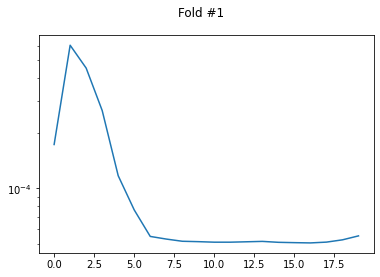

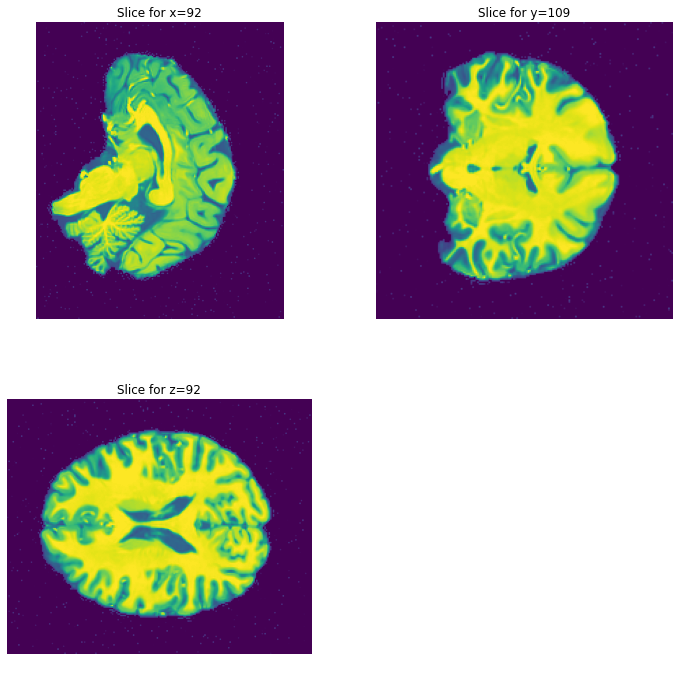

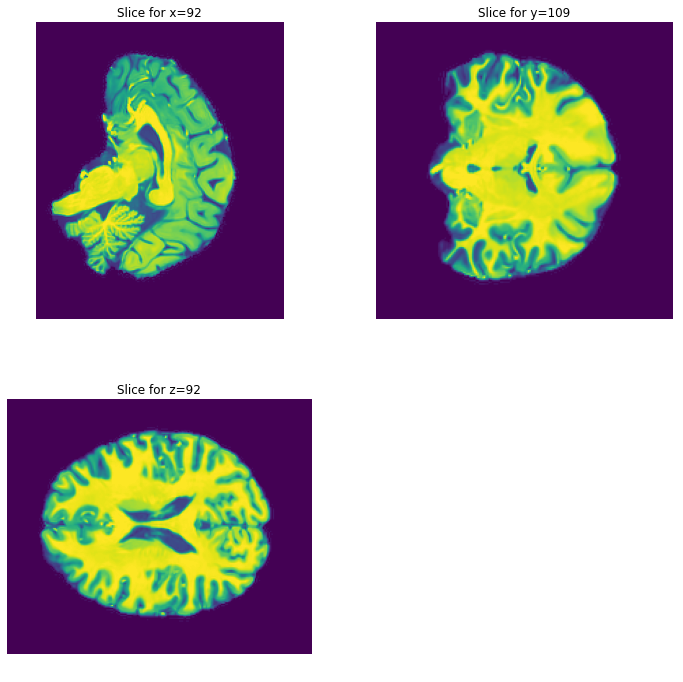

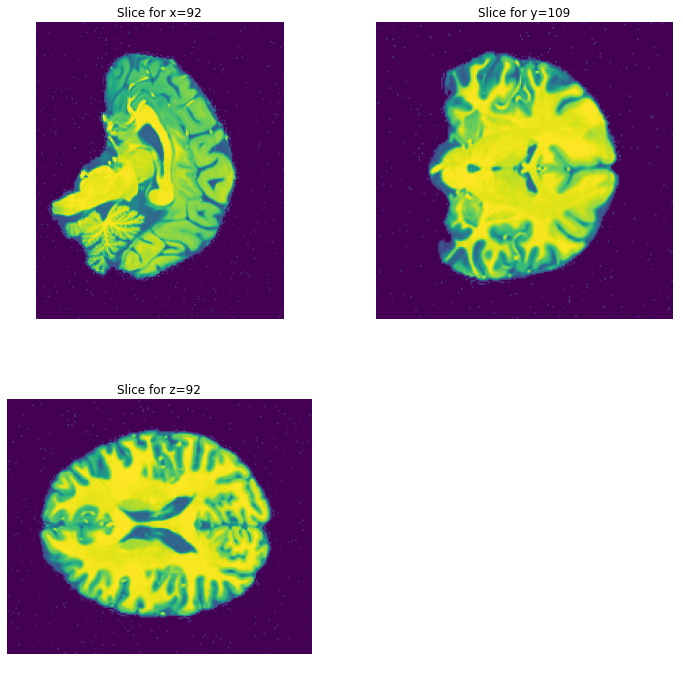

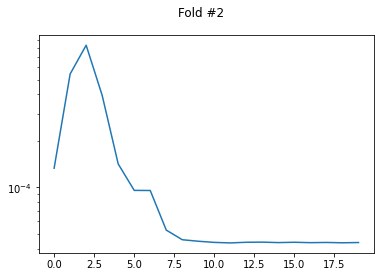

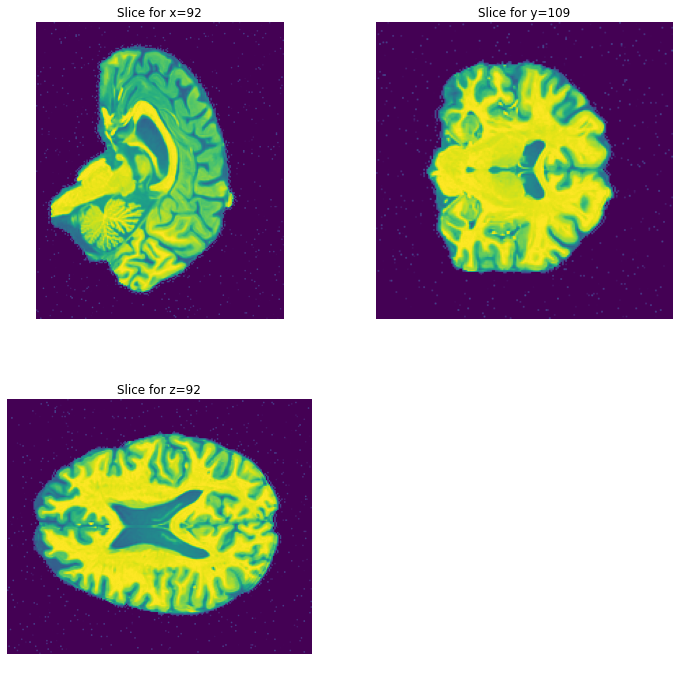

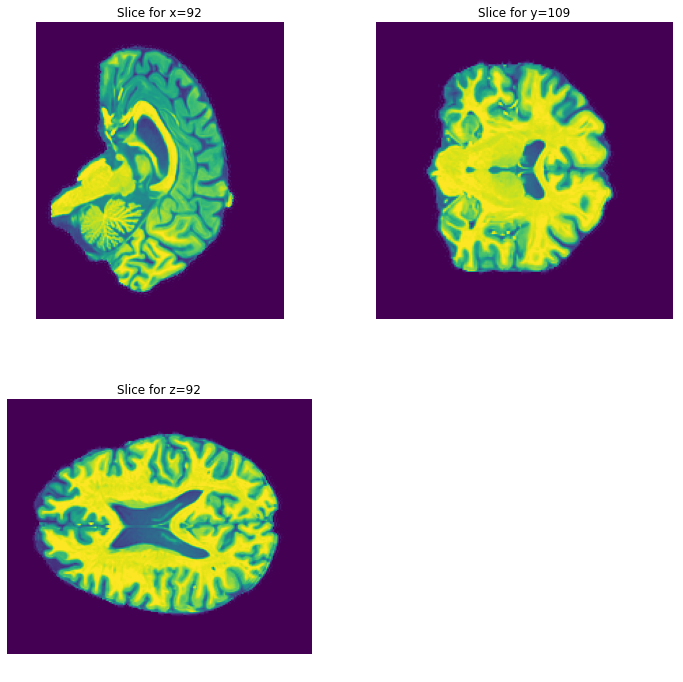

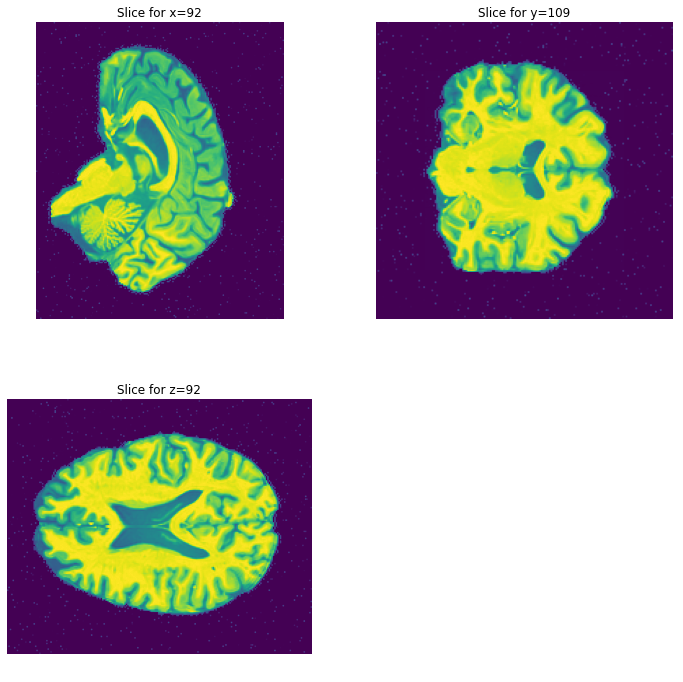

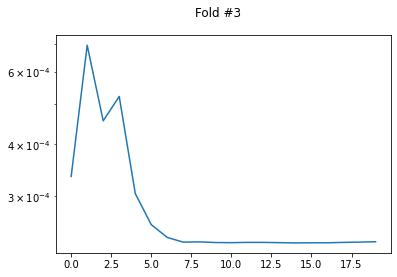

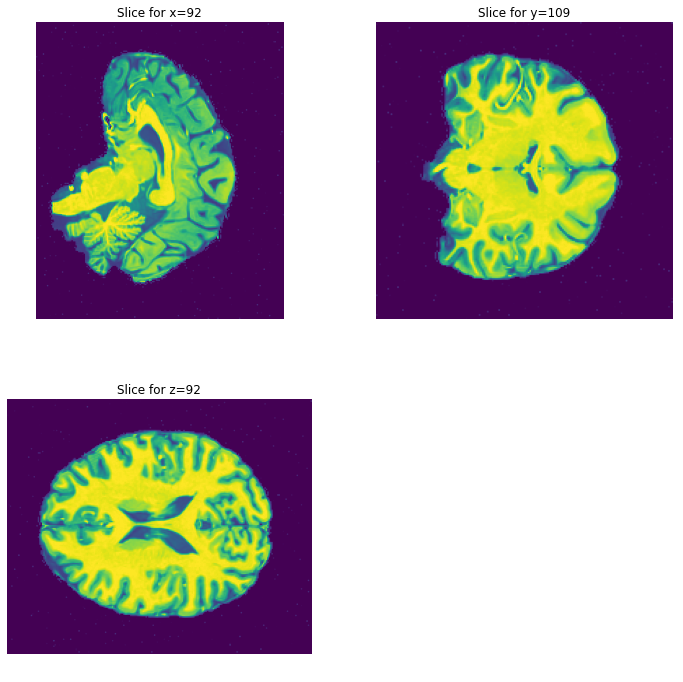

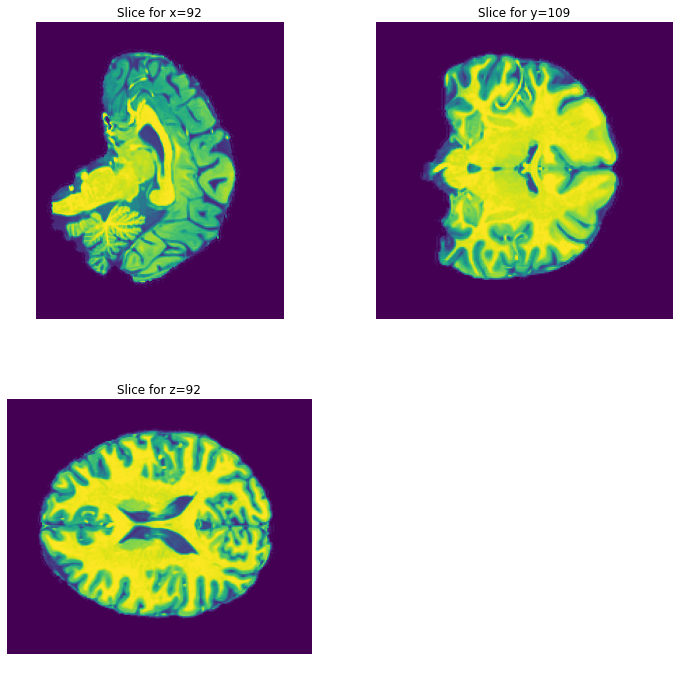

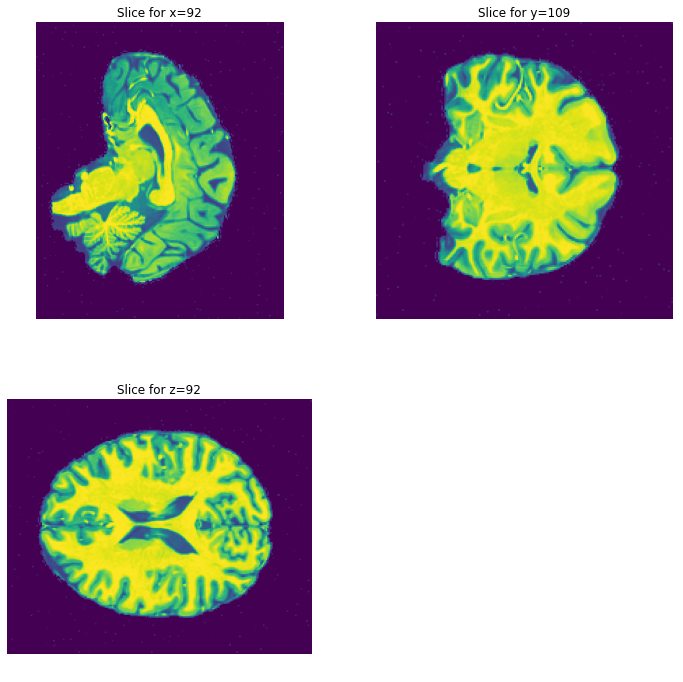

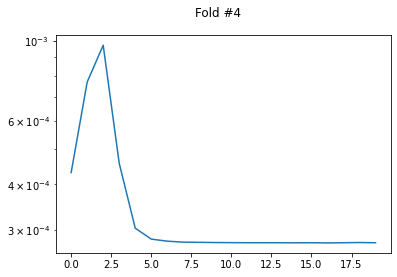

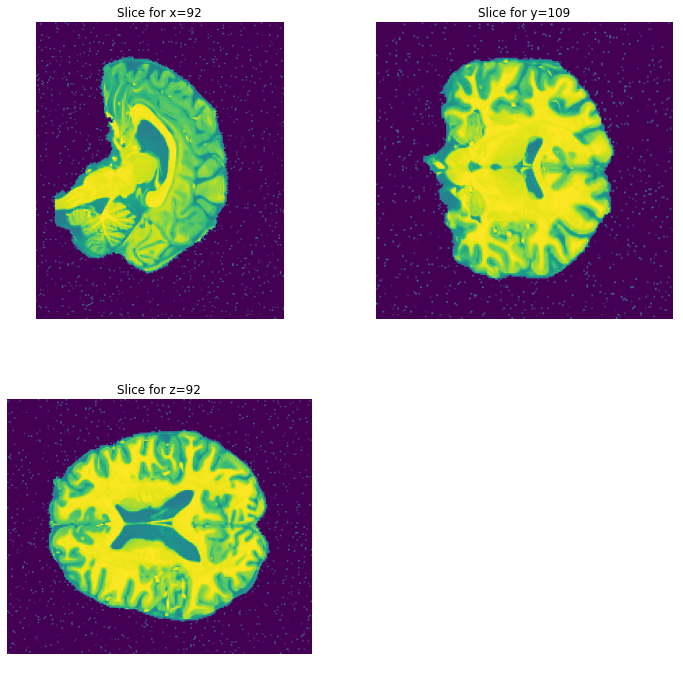

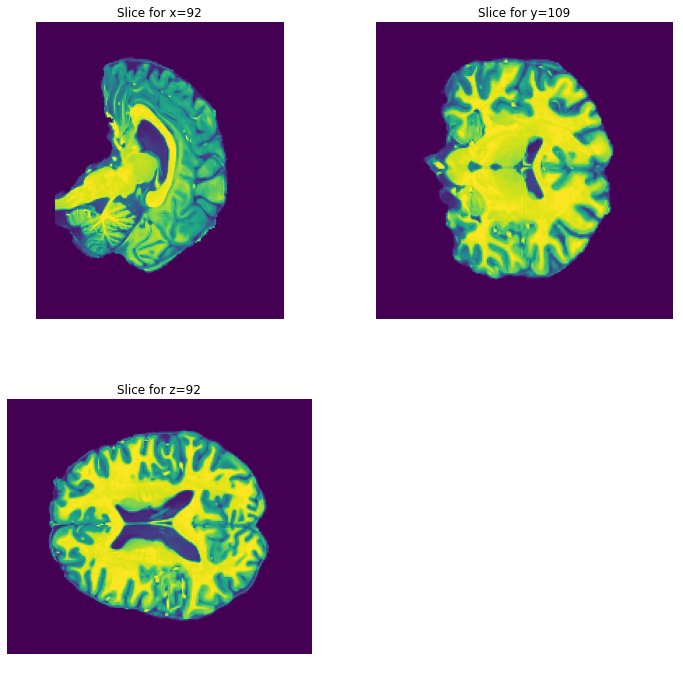

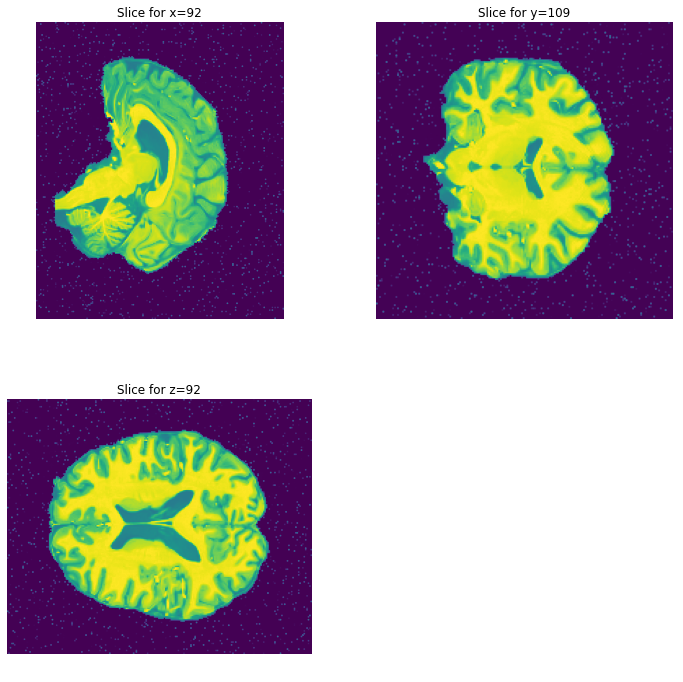

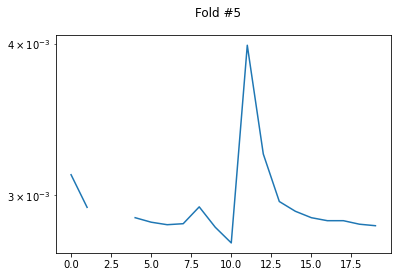

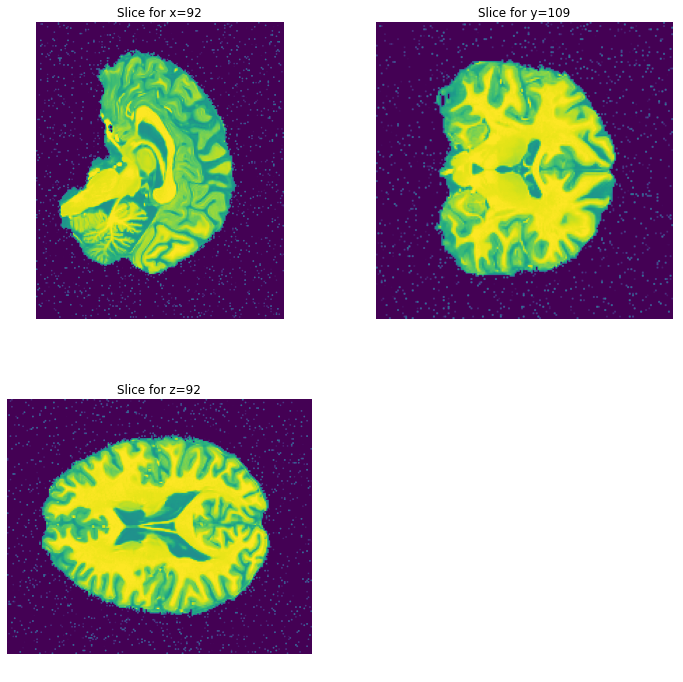

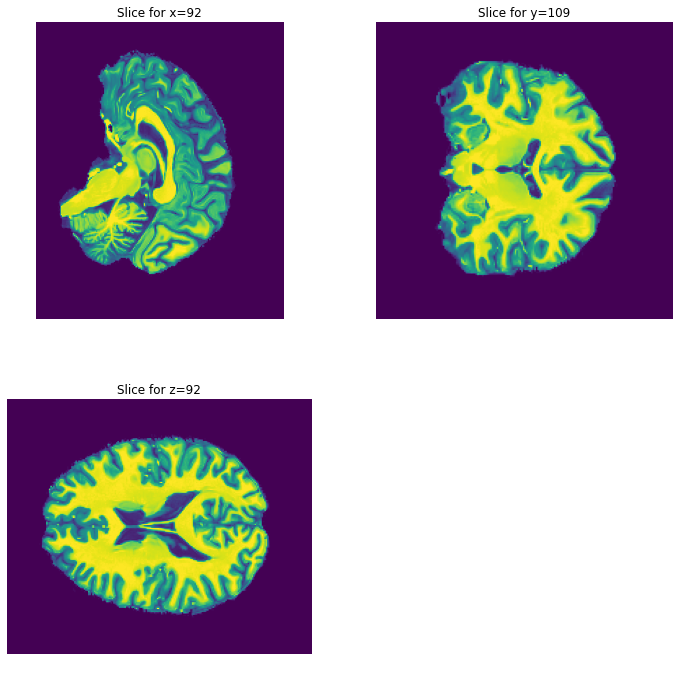

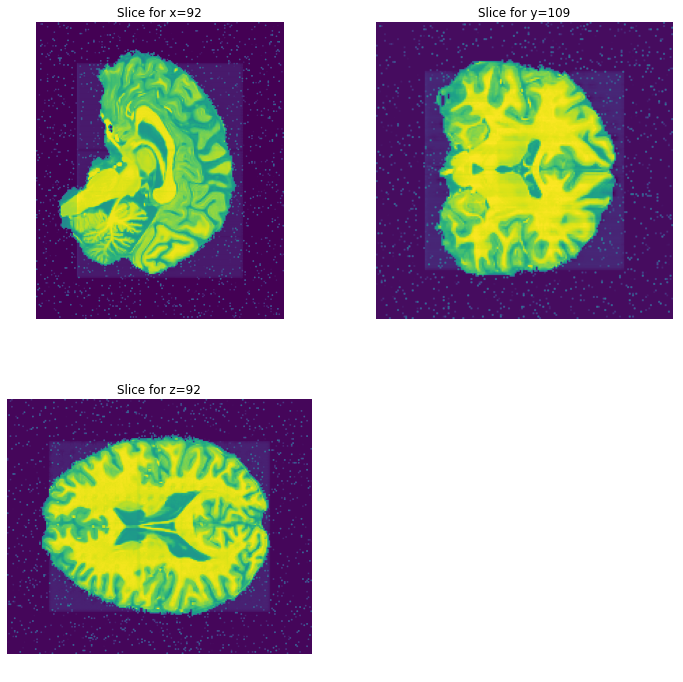

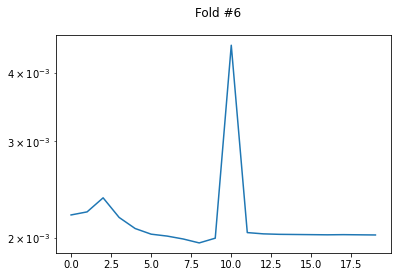

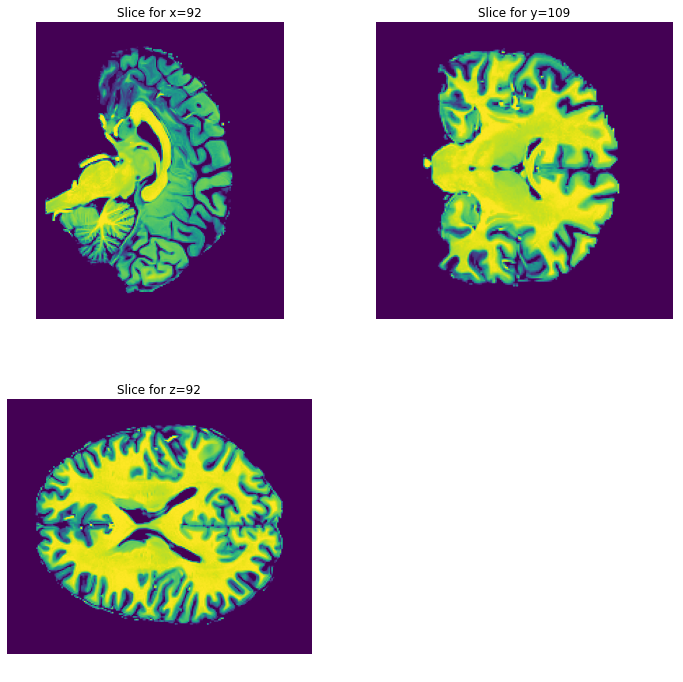

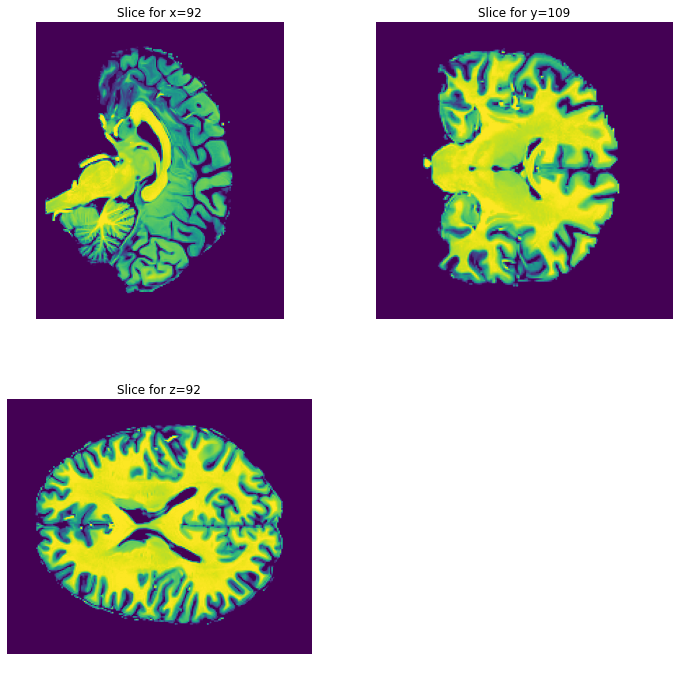

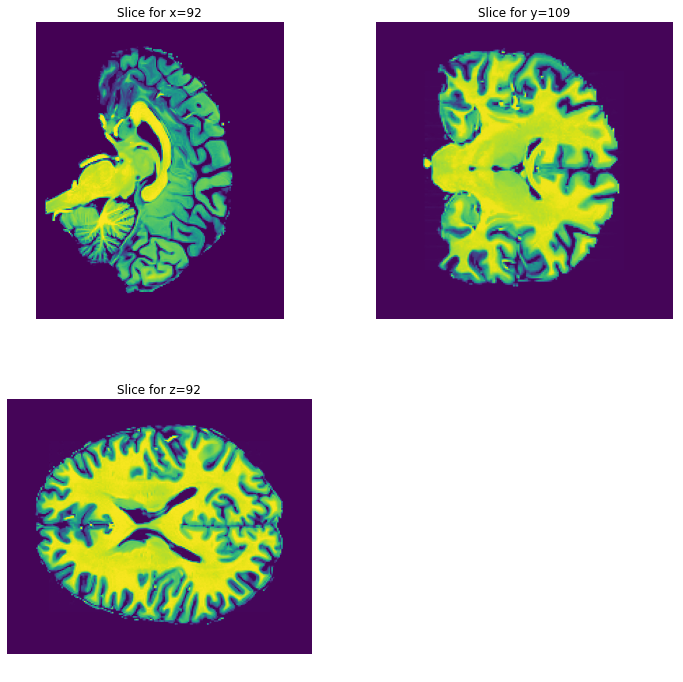

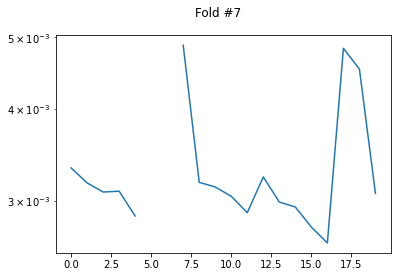

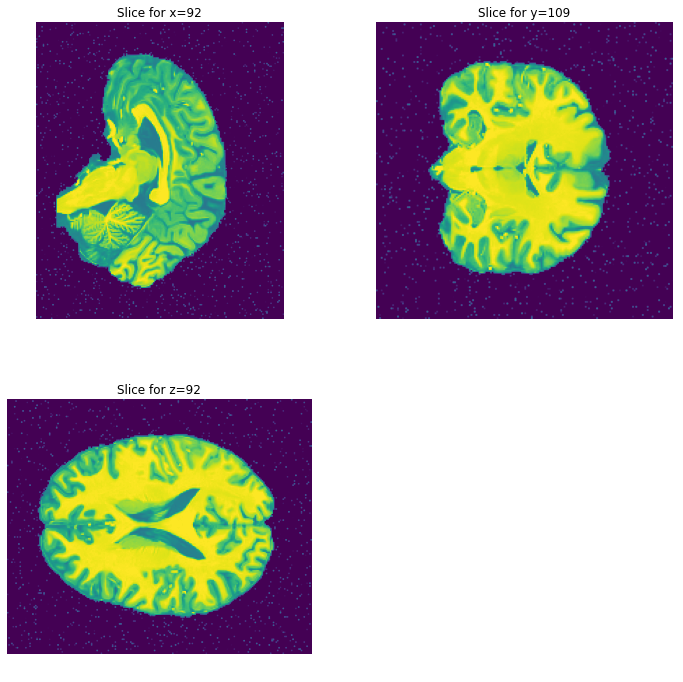

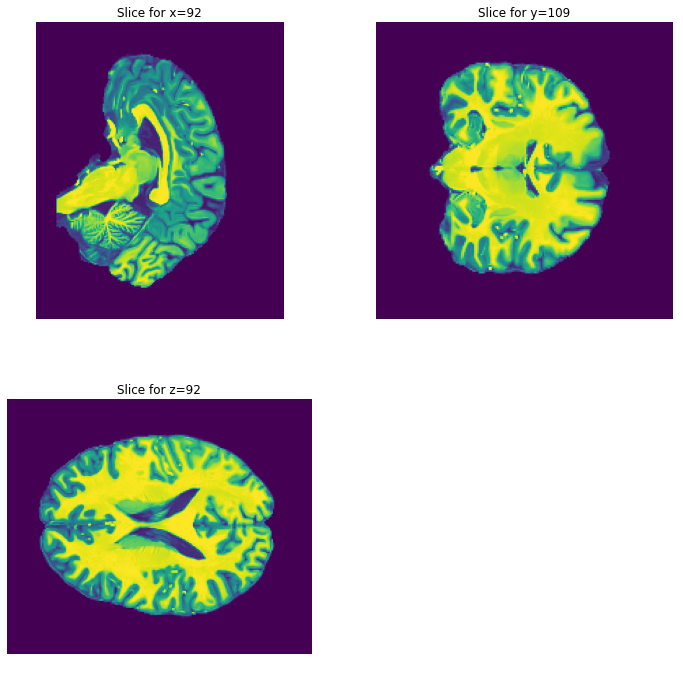

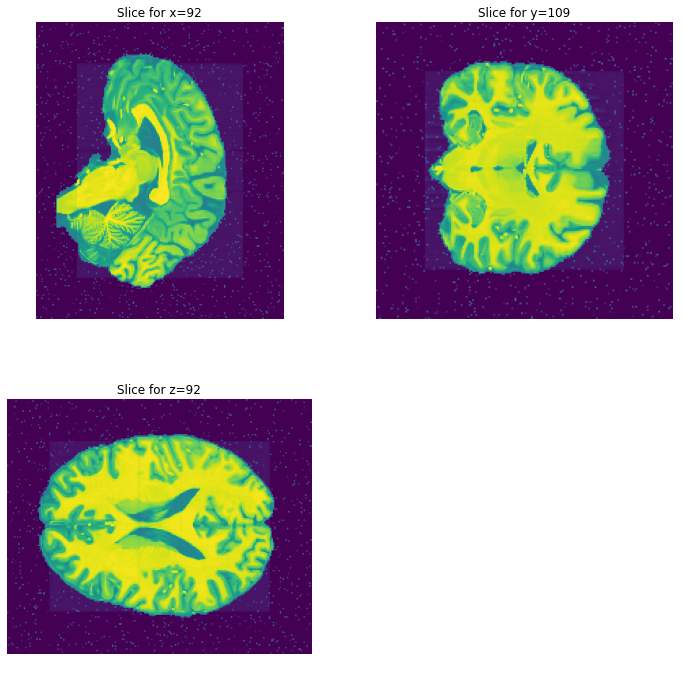

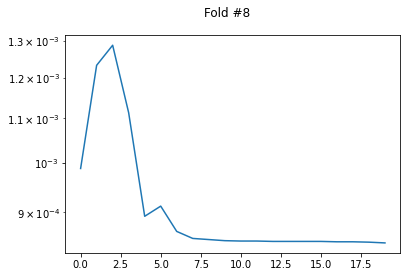

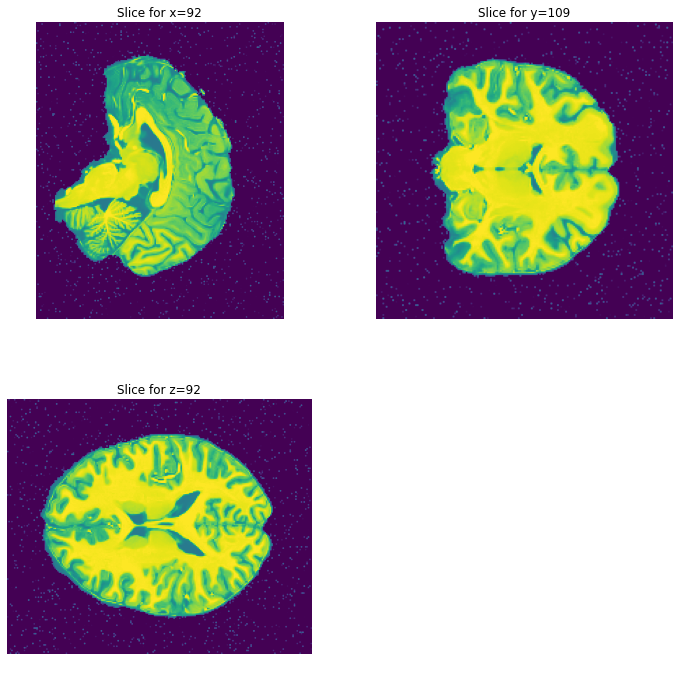

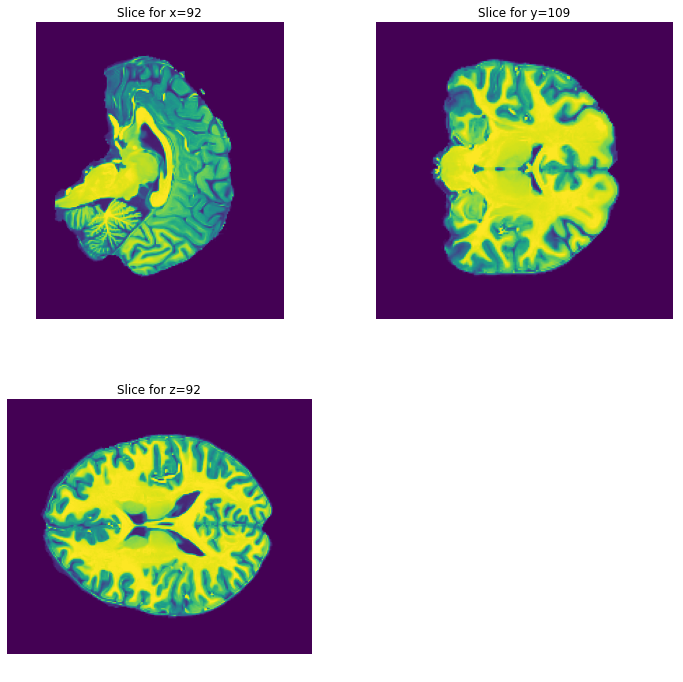

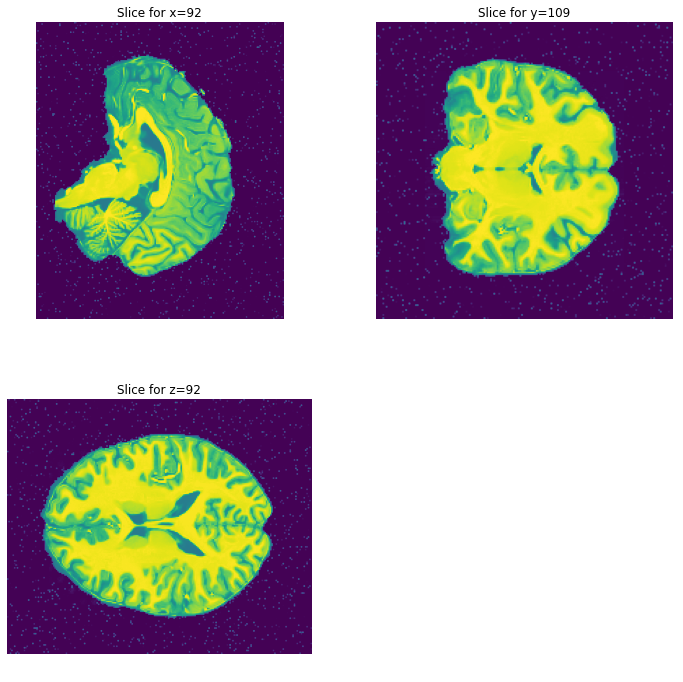

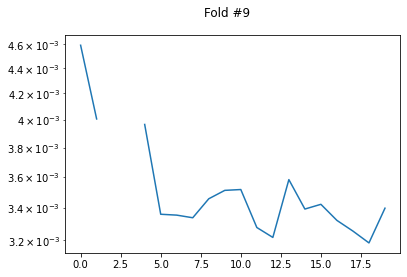

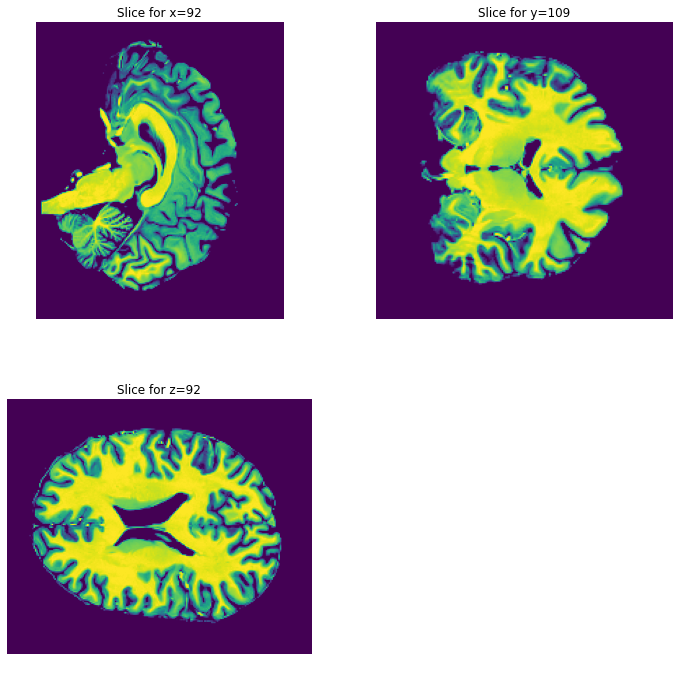

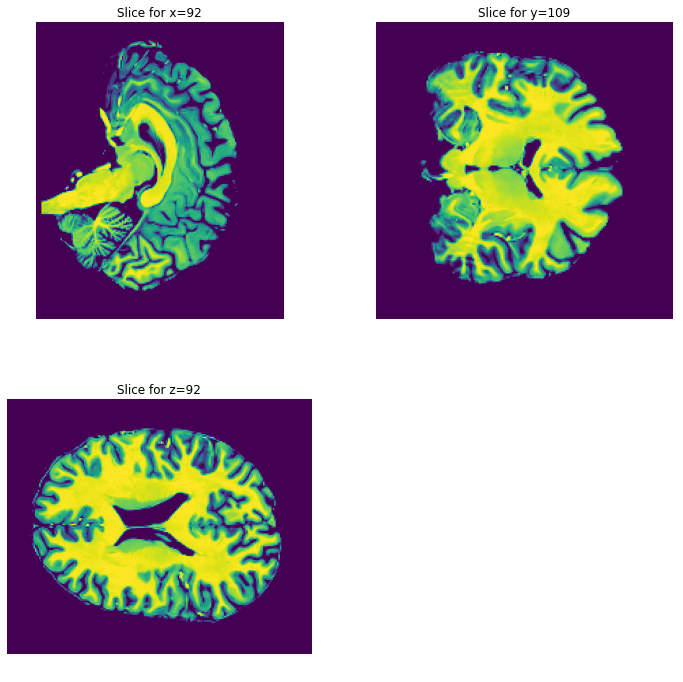

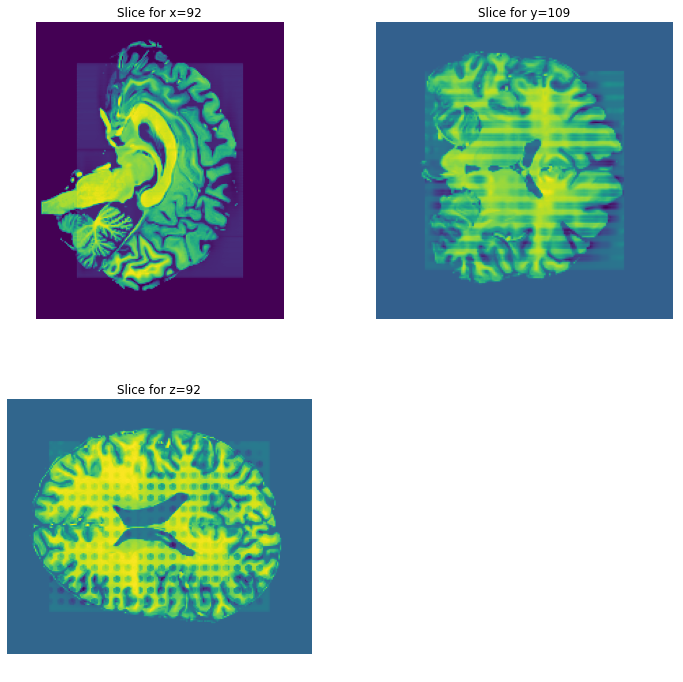

In [26]:
all_mae_history = []

for i in range(10):
  print(f'Fold {i}')
  train_ids = [j for j in range(10) if j!=i]
  train_dataset = instantiate_dataset(train_ids)
  lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.001,
    end_learning_rate=0.0001,
    decay_steps=10000,
    power=1.0)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
  model = WATNet()
  model.compile(optimizer=optimizer, loss=loss)
  
  history = model.fit(train_dataset, epochs=n_epochs, verbose=0)

  mae_history = history.history['loss']
  all_mae_history.append(mae_history)
  
  fig, ax = plt.subplots()
  ax.plot(range(len(mae_history)), mae_history)
  ax.set_yscale('log')
  fig.suptitle(f'Fold #{i}')
  fig.show()

  LQ_test, HQ_test, inferred_test = imgs_3T[i], imgs_7T[i], inference_function(imgs_3T[i], model)
  display_slices(LQ_test)
  display_slices(HQ_test)
  display_slices(inferred_test)

  print(np.abs(LQ_test).mean(), '-->', np.abs(inferred_test).mean())